                      State  median_income  total_population     white  \
state                                                                    
11     District of Columbia          77649            672391    273471   
72              Puerto Rico          19775           3468963   2389446   
36                 New York          62765          19798228  12638791   
06               California          67169          38982847  23607242   
41                   Oregon          56119           4025127   3416776   
53               Washington          66174           7169967   5500837   
46             South Dakota          54126            855444    724430   
50                  Vermont          57808            624636    590499   
17                 Illinois          61229          12854526   9236701   
31                 Nebraska          56675           1893921   1663612   
25            Massachusetts          74167           6789319   5358373   
12                  Florida          5

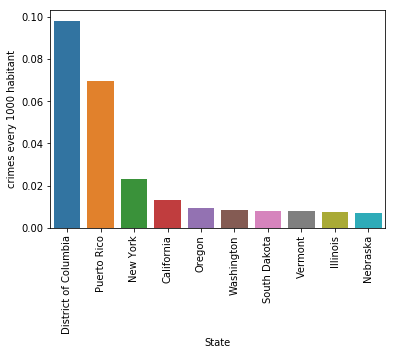

In [8]:
# Write an API call to the census API that gets data helpful for your table. If you can get it
# into a dataframe that matches your schema that is great but time may preclude the full
# transformation

import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from census import Census
from us import states

def read_csv(url):
  df= pd.read_csv(url) 
  return df


def main():
  #Load crimes data
  crimes = read_csv('US Terrorism Data - Sheet1.csv')

  #Group by state and count number of crimes
  n_crimes_per_state = pd.DataFrame(crimes.groupby(['provstate']).size())
  n_crimes_per_state.columns = ['# of crimes']  
  
  #Get census data...
  #Variables obtained from https://api.census.gov/data/2017/acs/acs5/variables.html
  total_population='B01003_001E,'
  median_income='B19013_001E,' 
  white='B02001_002E,'
  black='B02001_003E'

  variables='NAME,'+median_income+total_population+white+black

  key = 'a4cc2771a55261ebc7e0fcfb58bce7534ea22b6a'
  url = 'https://api.census.gov/data/2017/acs/acs5?get='+variables+'&for=state:*&key='+key

  #Api call to census data
  census_data = pd.read_json(url)

  #Move first row to header and remove first row
  census_data.columns = census_data.iloc[0] 
  census_data = census_data.iloc[1:]

  #Rename columns
  census_data=census_data.rename(columns={'NAME': 'State','B19013_001E': 'median_income', 'B01003_001E': 'total_population', 'B02001_002E':'white','B02001_003E':'african_american'})
  
  #Change column types to numeric
  census_data["median_income"] = pd.to_numeric(census_data["median_income"])
  census_data["total_population"] = pd.to_numeric(census_data["total_population"])
  census_data["white"] = pd.to_numeric(census_data["white"])
  census_data["african_american"] = pd.to_numeric(census_data["african_american"])

  
  #Join census data with crime data based on NAME (which is index of dataframe of n_crimes_per_state)
  crime_and_census = census_data.join(n_crimes_per_state, on='State')

  #Index of dataframe will be state_id according to the crime dataframe
  crime_and_census = crime_and_census.set_index('state')
  
  #Create column crimes every 1000 habitant
  crime_and_census['crimes every 1000 habitant']=crime_and_census['# of crimes']/crime_and_census['total_population']*1000

  crime_and_census = crime_and_census.sort_values('crimes every 1000 habitant',ascending=False)
  print(crime_and_census)
  
  #Print bar plot
  ax = sns.barplot(x="State", y="crimes every 1000 habitant", data=crime_and_census.head(10))
  plt.xticks(rotation=90)
  
main()

